In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import tensorflow as tf


2021-10-13 11:49:51.582692: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-13 11:49:51.582742: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BATCH_SIZE = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [3]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

2021-10-13 11:49:56.582561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-13 11:49:56.582588: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-13 11:49:56.582651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frcaud-Latitude-7420): /proc/driver/nvidia/version does not exist
2021-10-13 11:49:56.582876: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    'train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)
class_names = train_dataset.class_names
print(class_names)

Found 569 files belonging to 5 classes.
['0_Negative', '1_Primordial', '2_Primary', '3_Secondary', '4_Tertiary']


In [5]:
test_dataset = image_dataset_from_directory(
    'test',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 78 files belonging to 5 classes.


In [6]:
val_dataset = image_dataset_from_directory(
    'val',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 120 files belonging to 5 classes.


In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2021-10-13 11:50:09.028534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-13 11:50:09.048818: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1804800000 Hz


(10, 7, 7, 1280)


In [9]:
base_model.trainable = False

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [12]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 5)


In [13]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405  

In [16]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset)

Epoch 1/30
57/57 [==============================] - 10s 139ms/step - loss: 1.8908 - sparse_categorical_accuracy: 0.2654 - val_loss: 1.4042 - val_sparse_categorical_accuracy: 0.4667
Epoch 2/30
57/57 [==============================] - 8s 130ms/step - loss: 1.3428 - sparse_categorical_accuracy: 0.5009 - val_loss: 1.1611 - val_sparse_categorical_accuracy: 0.6250
Epoch 3/30
57/57 [==============================] - 8s 137ms/step - loss: 1.0811 - sparse_categorical_accuracy: 0.5888 - val_loss: 0.9946 - val_sparse_categorical_accuracy: 0.6417
Epoch 4/30
57/57 [==============================] - 11s 189ms/step - loss: 0.9543 - sparse_categorical_accuracy: 0.6257 - val_loss: 0.8820 - val_sparse_categorical_accuracy: 0.6583
Epoch 5/30
57/57 [==============================] - 9s 157ms/step - loss: 0.8324 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.7946 - val_sparse_categorical_accuracy: 0.6917
Epoch 6/30
57/57 [==============================] - 9s 152ms/step - loss: 0.7715 - sparse_categori

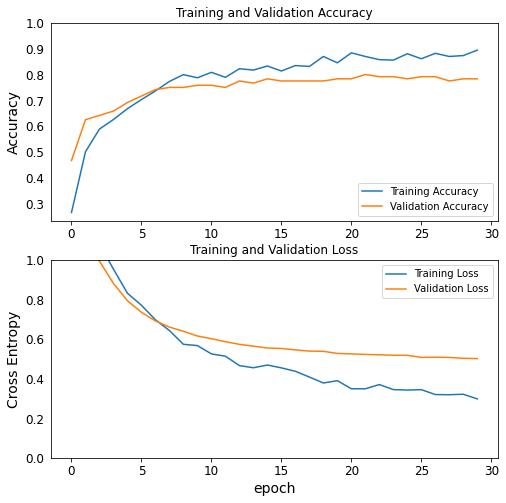

In [17]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = True
plt.rcParams['ytick.labelsize'] = True
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [8, 8]
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 78ms/step - loss: 0.4518 - sparse_categorical_accuracy: 0.8077
Test accuracy : 0.807692289352417


In [19]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis=1)
print('predictions:', predictions)
print('truth:      ', label_batch)

predictions: [1 0 0 0 1 3 0 1 0 0]
truth:       [0 4 0 0 1 3 0 1 0 0]


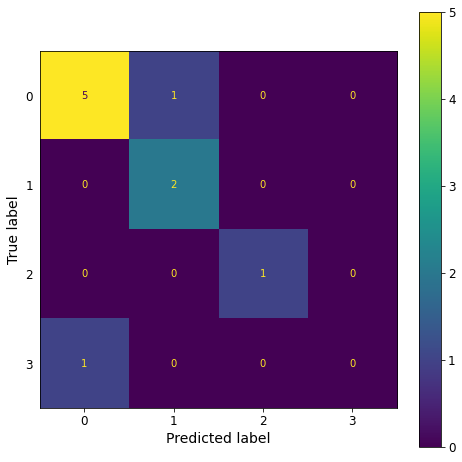

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(label_batch, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

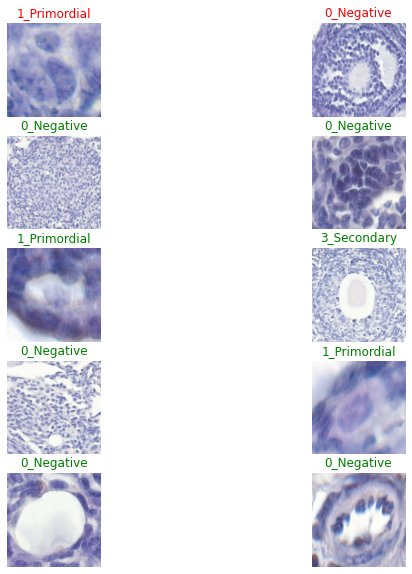

In [21]:
plt.figure(figsize=(10, 10))
for i in range(10):
  ax = plt.subplot(5, 2, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  if predictions[i] != label_batch[i]:
    color = 'red'
  else:
    color = 'green'
  plt.title(class_names[predictions[i]], color=color)
  plt.axis("off")

In [22]:
for images, labels in test_dataset.take(1):
    for i in range(4):
        im = tf.reshape(images[i], (1, 224, 224, 3))
        print(im.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


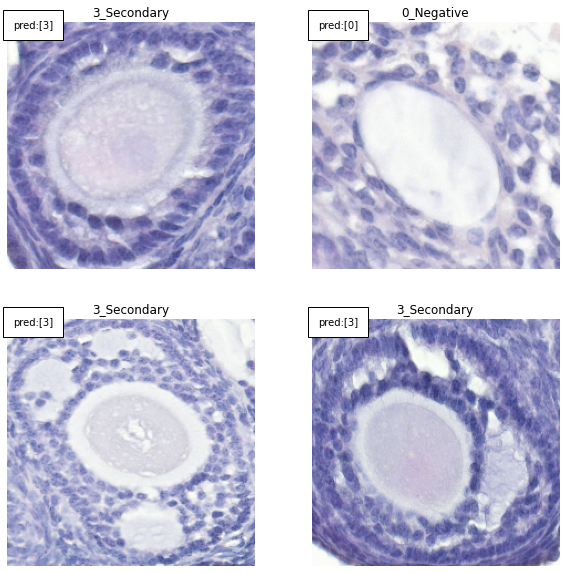

In [23]:
for images, labels in test_dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1, label="yo")
        ax.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        pred = model.predict(tf.reshape(images[i], (1, 224, 224, 3)))
        pred = np.argmax(pred, axis=1)
        ax.text(5,5,f'pred:{pred}', bbox={'facecolor': 'white', 'pad': 10})
        plt.axis("off")
